<a href="https://colab.research.google.com/github/rinaove/KAGGLE/blob/main/EDA_%26_Booking_Cancelation_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
jessemostipak_hotel_booking_demand_path = kagglehub.dataset_download('jessemostipak/hotel-booking-demand')

print('Data source import complete.')


Using Colab cache for faster access to the 'hotel-booking-demand' dataset.
Data source import complete.


## **Summary**

매년 1억 4천만 건 이상의 예약이 인터넷을 통해 이루어지며, 많은 호텔 예약은 Booking.com, Expedia.com, Hotels.com 등과 같은 많이 방문되는 여행 웹사이트를 통해 진행됩니다. Google 데이터에 따르면, 호텔 예약은 평균적으로 약 12주 전에 이루어집니다.

이 데이터셋은 **2015년부터 2017년 사이의** 예약 정보로, 평균 일일 요금(ADR), 도착 시간, 객실 유형, 특별 요청 등과 같은 **31개의 특성(feature)**을 포함하고 있습니다.

이 커널에서는 예약 정보에 대한 탐색적 데이터 분석(EDA), 일부 특징 공학(feature engineering), 변수 간 상관관계 검토, 하이퍼파라미터 튜닝, 그리고 가장 중요한 특성들과 그 흥미로운 분포 특성을 시각화하려고 합니다.

이러한 분석 과정을 통해, 나머지 특성들을 바탕으로 호텔 예약 취소 여부를 예측할 수 있는 최적의 모델을 찾는 것이 목표입니다. 특히 트리 기반 알고리즘(tree-based algorithms)을 사용하여, 과적합(overfitting)을 피하고 가장 높은 정확도를 내는 모델을 찾고자 합니다.

## **오늘의 목표**

* 재밌는 시각화 배우기
* 유의미한 피쳐 엔지니어링 배우기
* 과적합 피하는 하이퍼파라미터 튜닝 배우기
* (추가) 내가 옛날에 했던 분석 방법과 어떤점이 다른지 비교해보기

## **INTRODUCTION**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.inspection import permutation_importance

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import Data

hotel_data = pd.read_csv('/content/drive/MyDrive/Kaggle/hotel_bookings.csv')

In [ ]:
# Show first 10 rows

hotel_data.head(10)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03
5,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03
6,Resort Hotel,0,0,2015,July,27,1,0,2,2,...,No Deposit,NaN,NaN,0,Transient,107.0,0,0,Check-Out,2015-07-03
7,Resort Hotel,0,9,2015,July,27,1,0,2,2,...,No Deposit,303.0,NaN,0,Transient,103.0,0,1,Check-Out,2015-07-03
8,Resort Hotel,1,85,2015,July,27,1,0,3,2,...,No Deposit,240.0,NaN,0,Transient,82.0,0,1,Canceled,2015-05-06
9,Resort Hotel,1,75,2015,July,27,1,0,3,2,...,No Deposit,15.0,NaN,0,Transient,105.5,0,0,Canceled,2015-04-22


In [ ]:
# Data summary

hotel_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

## 1. Exploratory Data Analysis and Feature Engineering

이 부분에서는 일부 특성을 시각화하고, 타깃 변수와의 통계적 관계를 보여주고자 합니다. 이러한 분석은 데이터에 대한 전반적인 이해와 깊은 친숙도를 얻고, 극단값을 탐지하며, 명백한 오류를 식별하는 데 도움이 될 것입니다.

First graph is about exploring `hotel` feature which denotes type of the hotels. According to the below graph, approximately 34% of the data was booked for resort hotel and the rest of was booked for City Hotel.

/tmp/ipython-input-3877009777.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='hotel', data = hotel_data, palette='gist_earth')


Text(0, 0.5, 'Count')

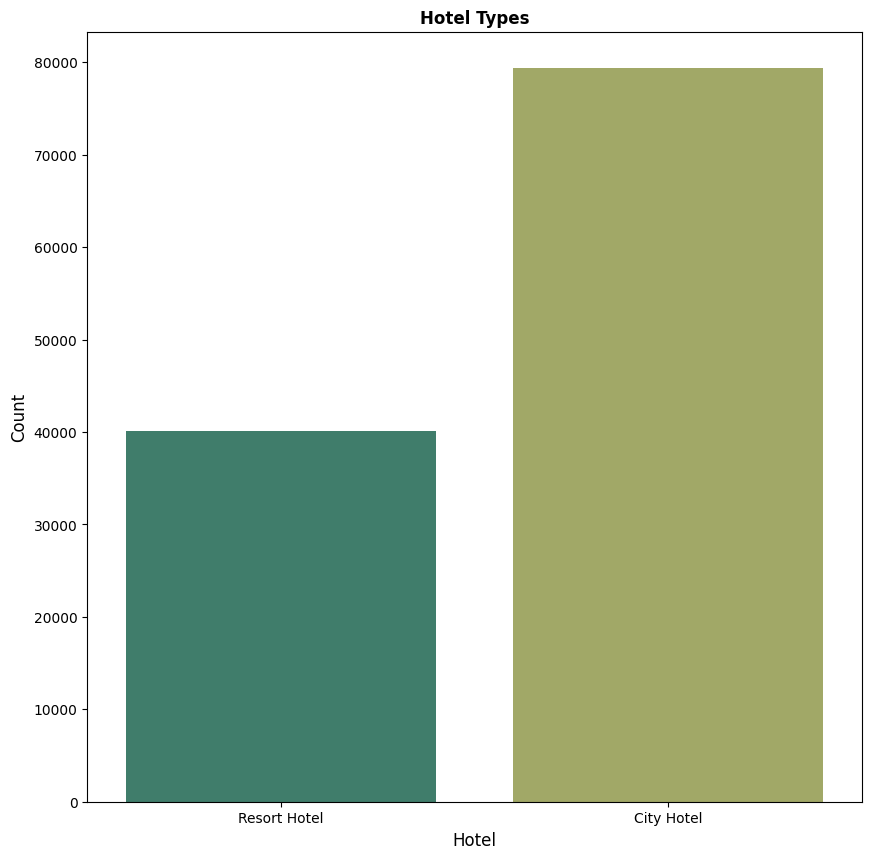

In [ ]:
# Hotel types details

plt.figure(figsize=(10,10))
sns.countplot(x='hotel', data = hotel_data, palette='gist_earth')
plt.title('Hotel Types', weight='bold')
plt.xlabel('Hotel', fontsize=12)
plt.ylabel('Count', fontsize=12)

Now, let's dive into the target value of data. The numbers are similar with hotel features. While 37% of booking canceled, 63% of booking is not canceled. These numbers also show that there is no balanced problem on the target value.  

> ‼️ 클래스 불균형 (balanced problem) 이 없다는 것은?

이 경우 모델이 한쪽 클래스만 예측하는 단순 전략으로는 높은 성능을 내기 어렵고, 진짜로 데이터 특성을 잘 학습해야 함.

/tmp/ipython-input-3795245566.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='is_canceled', data= hotel_data, palette='gist_stern', orient = 'v')


Text(0, 0.5, 'Canceled or Not Canceled')

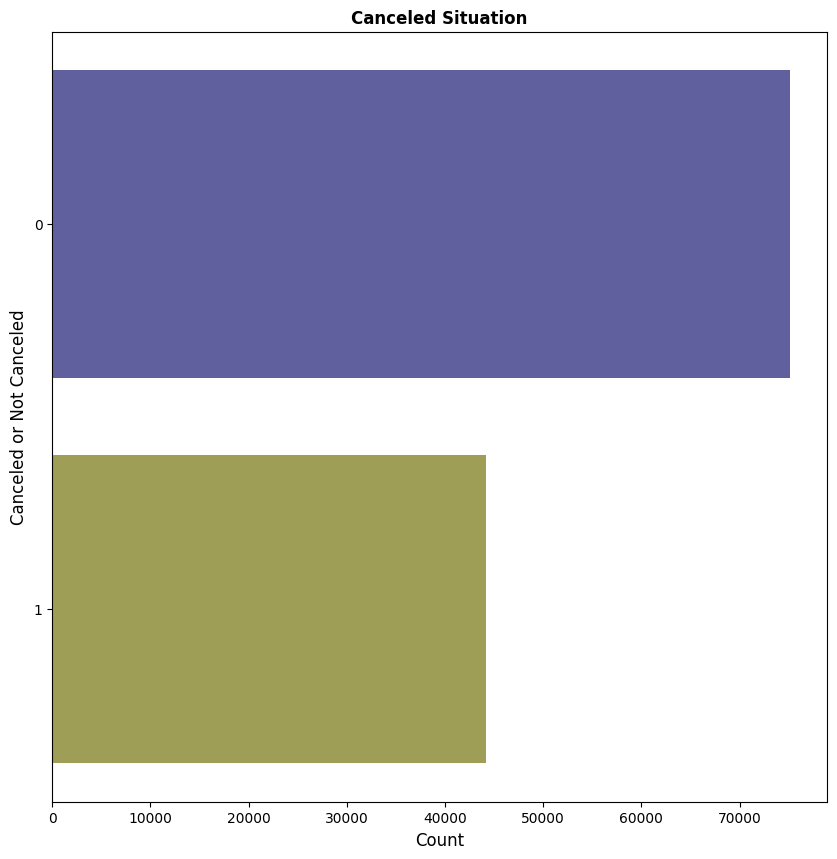

In [ ]:
# `is_canceled` graph

plt.figure(figsize=(10,10))
sns.countplot(y='is_canceled', data= hotel_data, palette='gist_stern', orient = 'v')
plt.title('Canceled Situation', weight='bold')
plt.xlabel('Count', fontsize=12)
plt.ylabel('Canceled or Not Canceled', fontsize=12)

Below graph shows the relationship of `arrival_date_year` to `lead_time` with booking cancellation status. The graph created by violin plot. Violin plot is a hybrid of** box plot and density plot**. It shows the distribution of the data.

Three violin plots are correponding to three different years. For canceled booking, means and interquartile ranges are similar in all years. But the shapes of the distributions are quite different from each other. On the other hand distribution of not-canceled booking are almost the same.
For all years and every booking situation, the small number of large lead time values are pulling the mean up. It shows that the mean is higher than the median.

/tmp/ipython-input-3982183551.py:4: FutureWarning: 

The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method=0.2`, but please see docs for the new parameters
and update your code. This will become an error in seaborn v0.15.0.

  sns.violinplot(x='arrival_date_year', y ='lead_time', hue="is_canceled", data=hotel_data, palette="Set3", bw=.2,


Text(0, 0.5, 'Lead Time')

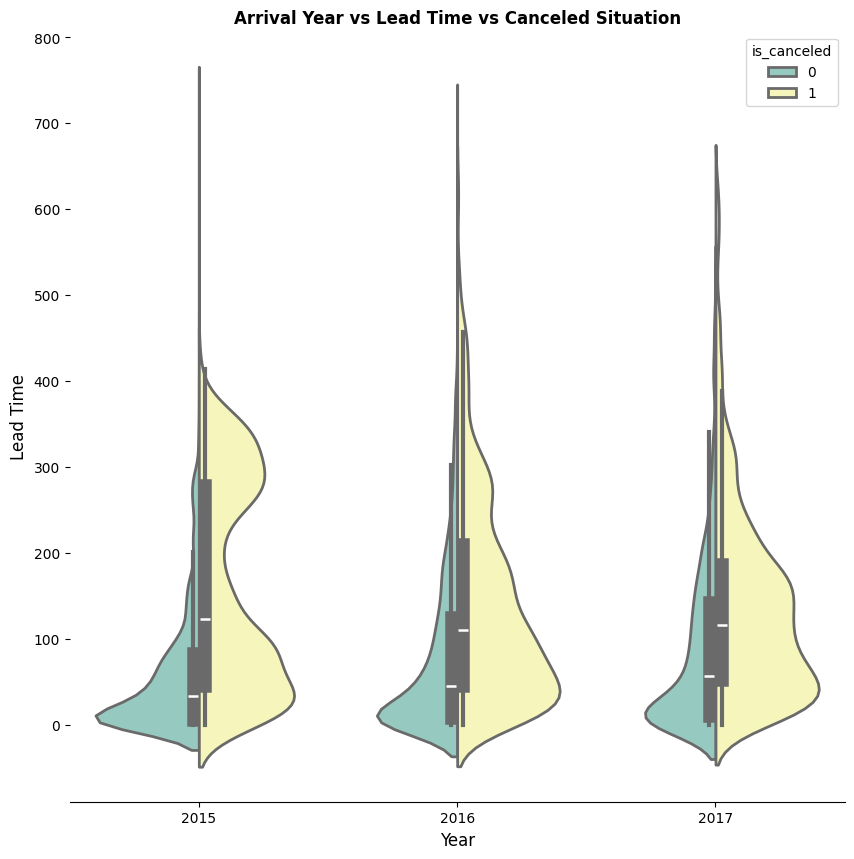

In [ ]:
# `arrival_date_year` vs `lead_time` vs `is_canceled` exploration with violin plot

plt.figure(figsize=(10,10))
sns.violinplot(x='arrival_date_year', y ='lead_time', hue="is_canceled", data=hotel_data, palette="Set3", bw=.2,
               cut=2, linewidth=2, inner= 'box', split = True)
sns.despine(left=True)
plt.title('Arrival Year vs Lead Time vs Canceled Situation', weight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Lead Time', fontsize=12)

> 재밌는 시각화: 박스플롯

* 데이터 분포의 모양을 보고 싶을 때

예: 평균은 같지만 한 그룹은 단봉, 다른 그룹은 이봉(bimodal)일 수 있음. 박스플롯만 보면 이 차이를 놓침.

* 그룹 간 분포를 비교할 때

예: "연도별 예약 취소 lead time 분포" → 각 그룹의 모양이 어떻게 다른지 한눈에 파악 가능.

* 샘플 크기가 충분히 많을 때

샘플이 적으면 밀도 추정이 부정확해서 오히려 왜곡됨.

Another exploration is made for the `arrival_date_month` feature. First month names converted to the numbers. It will help easier analysis.

In [ ]:
#`arrival_date_month` names converted to the numbers

hotel_data['arrival_date_month'].replace({'January' : '1',
        'February' : '2',
        'March' : '3',
        'April' : '4',
        'May' : '5',
        'June' : '6',
        'July' : '7',
        'August' : '8',
        'September' : '9',
        'October' : '10',
        'November' : '11',
        'December' : '12'}, inplace=True)

/tmp/ipython-input-2456198075.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  hotel_data['arrival_date_month'].replace({'January' : '1',


/tmp/ipython-input-3972968644.py:5: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  order=pd.value_counts(hotel_data['arrival_date_month']).index, palette='YlOrBr_r')
/tmp/ipython-input-3972968644.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='arrival_date_month', data = hotel_data,


Text(0, 0.5, 'Count')

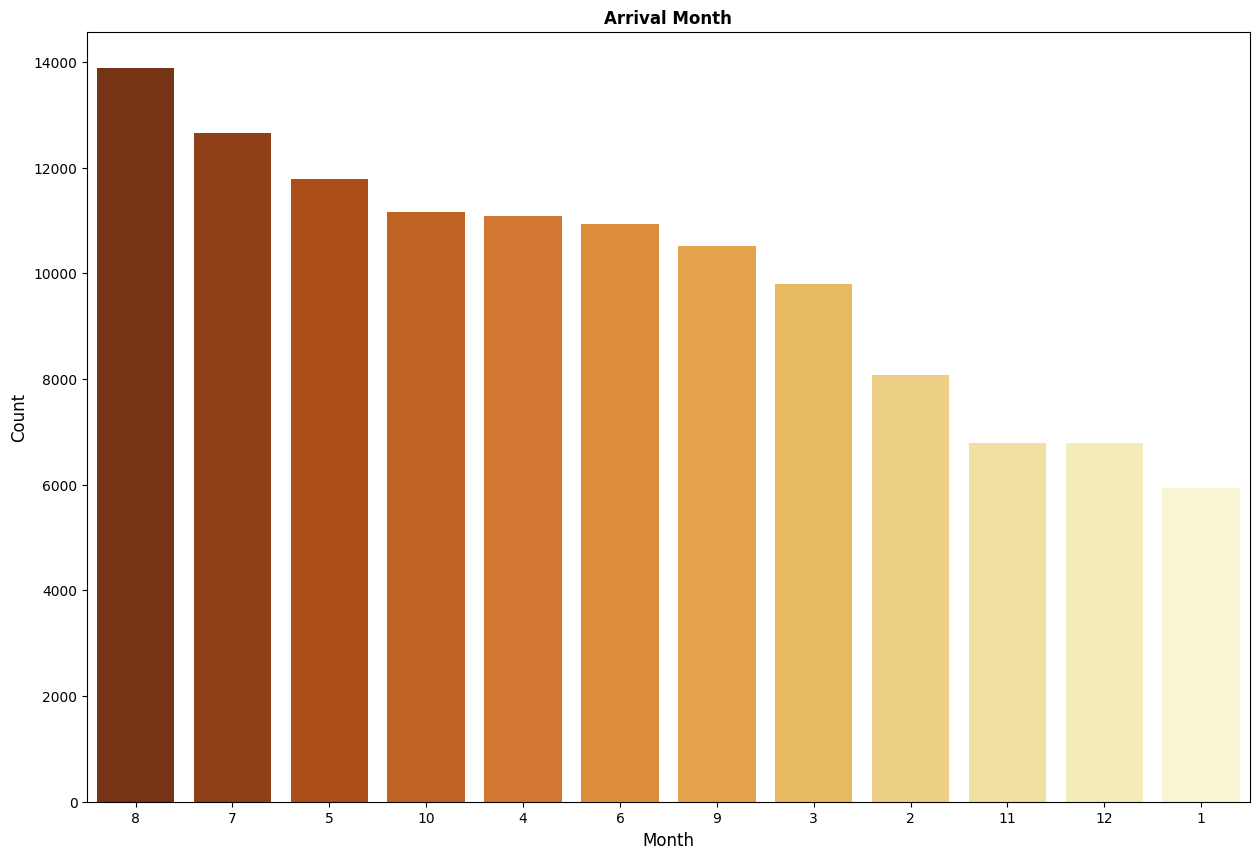

In [ ]:
#`arrival_date_month` exploration

plt.figure(figsize=(15,10))
sns.countplot(x='arrival_date_month', data = hotel_data,
              order=pd.value_counts(hotel_data['arrival_date_month']).index, palette='YlOrBr_r')
plt.title('Arrival Month', weight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Count', fontsize=12)

The above graph is showing the number of bookings for each month. According to that, August is the busiest month and January is the most unoccupied month. It is half as busy as August.

Another important features which are related to time are `stays_in_week_nights` and `stays_in_weekend_night` features. The below table shows the relationship between these two features. According to that, there is some missing data. 715 values are inputted zero both weekend and weeknights. However, this missing data is small enough to neglect.

In [ ]:
# Table of `stay_in_weekend` and `stay_in_week_nights` features

pd.crosstab(index = hotel_data['stays_in_week_nights'],columns=hotel_data['stays_in_weekend_nights'], margins=True, margins_name = 'Total').iloc[:10]

stays_in_weekend_nights,0,1,2,3,4,5,6,7,8,9,10,12,13,14,16,18,19,Total
stays_in_week_nights,,,,,,,,,,,,,,,,,,
0,715,4569,2361,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7645
1,16451,7326,6533,0,0,0,0,0,0,0,0,0,0,0,0,0,0,30310
2,17956,8979,6749,0,0,0,0,0,0,0,0,0,0,0,0,0,0,33684
3,11564,6152,4542,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22258
4,4482,2412,2669,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9563
5,830,1188,8655,310,94,0,0,0,0,0,0,0,0,0,0,0,0,11077
6,0,0,851,301,347,0,0,0,0,0,0,0,0,0,0,0,0,1499
7,0,0,446,399,184,0,0,0,0,0,0,0,0,0,0,0,0,1029
8,0,0,393,131,132,0,0,0,0,0,0,0,0,0,0,0,0,656


The above table brings an idea about creating a new feature. Which is indicated `just_stay_weekend`, `just_stay_weekday` and `stay_both_weekday_and_weekday`. These 715 values which are not assigned any feature, indicated as undefined_data.

In [ ]:
## Creating new feature: `Weekday vs Weekend`

pd.options.mode.chained_assignment = None
def week_function(feature1, feature2, data_source):
    data_source['weekend_or_weekday'] = 0
    for i in range(0, len(data_source)):
        if feature2.iloc[i] == 0 and feature1.iloc[i] > 0:
            hotel_data['weekend_or_weekday'].iloc[i] = 'stay_just_weekend'
        if feature2.iloc[i] > 0 and feature1.iloc[i] == 0:
            hotel_data['weekend_or_weekday'].iloc[i] = 'stay_just_weekday'
        if feature2.iloc[i] > 0 and feature1.iloc[i] > 0:
            hotel_data['weekend_or_weekday'].iloc[i] = 'stay_both_weekday_and_weekend'
        if feature2.iloc[i] == 0 and feature1.iloc[i] == 0:
            hotel_data['weekend_or_weekday'].iloc[i] = 'undefined_data'


week_function(hotel_data['stays_in_weekend_nights'],hotel_data['stays_in_week_nights'], hotel_data)

/tmp/ipython-input-2893007613.py:14: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  hotel_data['weekend_or_weekday'].iloc[i] = 'undefined_data'
/tmp/ipython-input-2893007613.py:14: FutureWarning: Setting an item of incompatible dtype is depre

> 코드

* `pd.options.mode.chained_assignment = None` → 기본값, 경고를 띄움

Next graph is about `weekend_or_weekday` feature's relationship with `arrival_date_month`. Below bar graph shows that most bookings were made to stay only for weekdays or both weekdays and weekends. On the other, numbers of staying just the weekend category are quite low compared to other categories.

Text(0, 0.5, 'Count')

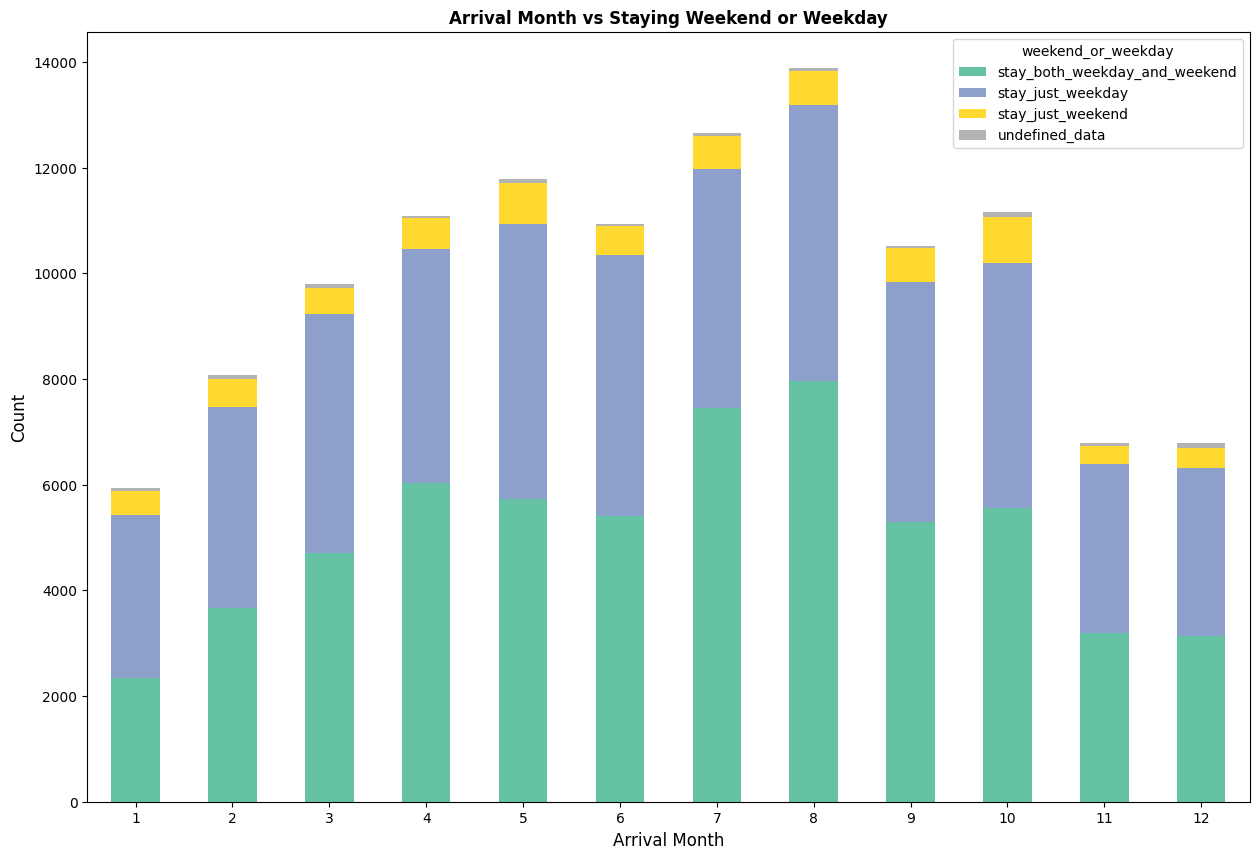

In [ ]:
#`arrival_date_month` vs `weekend_or_weekday` graph

hotel_data['arrival_date_month']= hotel_data['arrival_date_month'].astype('int64')
group_data = hotel_data.groupby([ 'arrival_date_month','weekend_or_weekday']).size().unstack(fill_value=0)
group_data.sort_values('arrival_date_month', ascending = True).plot(kind='bar',stacked=True, cmap='Set2',figsize=(15,10))
plt.title('Arrival Month vs Staying Weekend or Weekday', weight='bold')
plt.xlabel('Arrival Month', fontsize=12)
plt.xticks(rotation=360)
plt.ylabel('Count', fontsize=12)

> 새로운 파생변수

* total_nights은 만들었는데 주중, 주말, 둘다, 아예 아닌 경우로 나눈 점이 좋았음.
* 근데 육안으로 봤을 때는 월마다 별 차이가 없다

> `unstack`

* unstack(fill_value=0) 그룹 결과를 피벗(pivot) 형태로 변환.

| arrival\_date\_month | Weekday | Weekend |
| -------------------- | ------- | ------- |
| January              | 1200    | 450     |
| February             | 980     | 300     |
| March                | 1500    | 600     |
| ...                  | ...     | ...     |


Another feature engineering is made for `children` and `babies` features. Since, there is no obvious difference, these features gathered under the one feature which name is `all_children`.

In [ ]:
# Create new feature:`all_children` with merge children and baby features

hotel_data['all_children'] = hotel_data['children'] + hotel_data['babies']
pd.crosstab(hotel_data['adults'], hotel_data['all_children'], margins=True, margins_name = 'Total').iloc[:10]

all_children,0.0,1.0,2.0,3.0,9.0,10.0,Total
adults,,,,,,,
0,180,4,205,14,0,0,403
1,22577,286,157,6,1,0,23027
2,81557,4658,3369,91,0,2,89677
3,5665,495,41,0,0,0,6201
4,59,3,0,0,0,0,62
5,2,0,0,0,0,0,2
6,1,0,0,0,0,0,1
10,1,0,0,0,0,0,1
20,2,0,0,0,0,0,2


Below the donut pie graph shows the meal categories. There is a big difference in the `Bed&Breakfast` category and the others. Almost 80% of bookings reserved for `Bed&Breakfast`.

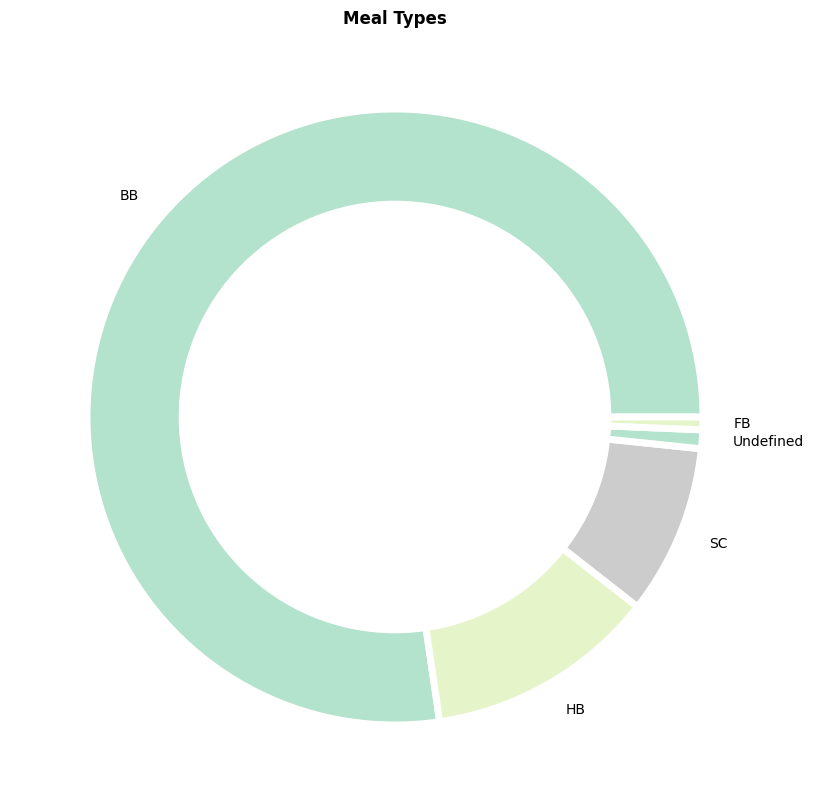

In [ ]:
# `Meal` feature donut chart

meal_labels= ['BB','HB', 'SC', 'Undefined', 'FB']
size = hotel_data['meal'].value_counts()
plt.figure(figsize=(10,10))
cmap =plt.get_cmap("Pastel2")
colors = cmap(np.arange(3)*4)
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(size, labels=meal_labels, colors=colors, wedgeprops = { 'linewidth' : 5, 'edgecolor' : 'white' })
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Meal Types', weight='bold')
plt.show()

> 재밌는 시각화: 도넛 차트

* my_circle = plt.Circle((0,0), 0.7, color='white'): 0,0에 반지름 0.7인 원 그리기

The below table shows frequency details about meal types according to the hotel types. Following the results, 67% of `Bed&Breakfast` booking made for `City Hotel` and almost every `Full Board` bookings made in the `Resort Hotel`.

In [ ]:
# Groupby `Meal` and `Hotel` features

group_meal_data = hotel_data.groupby(['hotel','meal']).size().unstack(fill_value=0).transform(lambda x: x/x.sum())
group_meal_data.applymap('{:.2f}'.format)

/tmp/ipython-input-1558459236.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  group_meal_data.applymap('{:.2f}'.format)


meal,BB,FB,HB,SC,Undefined
hotel,,,,,
City Hotel,0.67,0.06,0.44,0.99,0.00
Resort Hotel,0.33,0.94,0.56,0.01,1.00


The below graph gives information about the location which bookings made in. According to that, there is an apparent difference in booking location between Portugal and the others. Approx. 40% of all bookings made in the same location: Portugal.

/tmp/ipython-input-11847583.py:5: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  order=pd.value_counts(hotel_data['country']).iloc[:10].index, palette="brg")
/tmp/ipython-input-11847583.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='country', data=hotel_data,


Text(0, 0.5, 'Count')

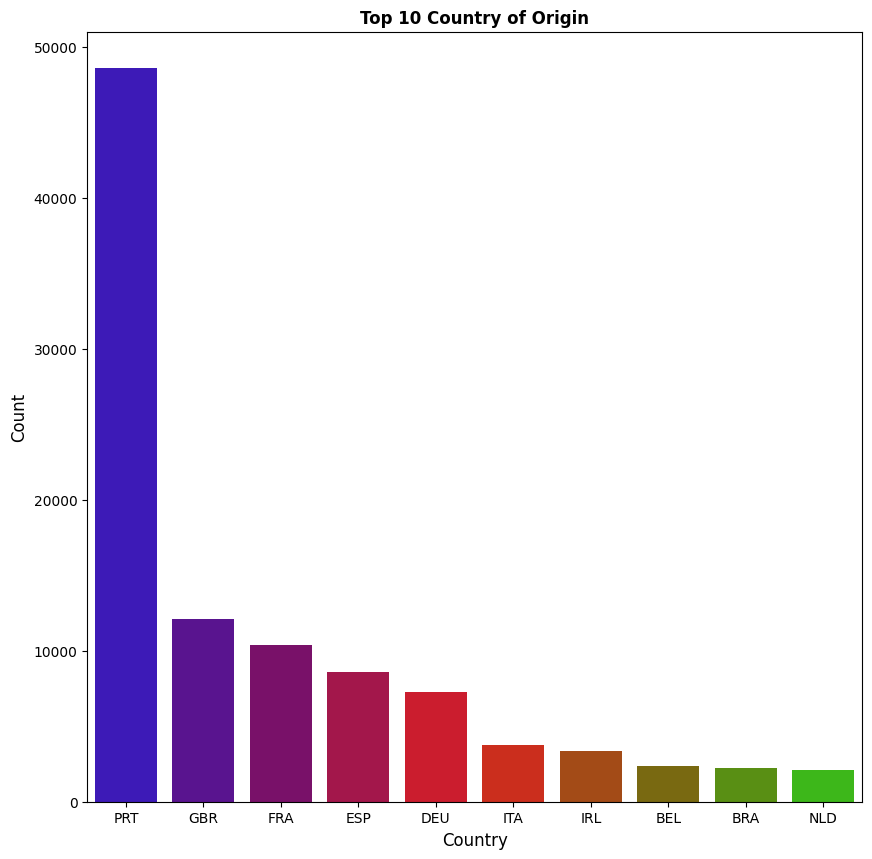

In [ ]:
# Create Top 10 Country of Origin graph

plt.figure(figsize=(10,10))
sns.countplot(x='country', data=hotel_data,
              order=pd.value_counts(hotel_data['country']).iloc[:10].index, palette="brg")
plt.title('Top 10 Country of Origin', weight='bold')
plt.xlabel('Country', fontsize=12)
plt.ylabel('Count', fontsize=12)

The statistics show that online hotel and airline reservations are increased in recent years. Most people complete their reservation via their smartphones. The below graphs is summarise these statistics. More than 45% of bookings are made via `Online Travel Agents` and around 20% of bookings made via `Offline Travel Agents`. Less than 20% of bookings made directly without any agents.

/tmp/ipython-input-2535430318.py:5: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  order=pd.value_counts(hotel_data['market_segment']).index)
/tmp/ipython-input-2535430318.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(hotel_data['market_segment'], palette='spring_r',


Text(0, 0.5, 'Count')

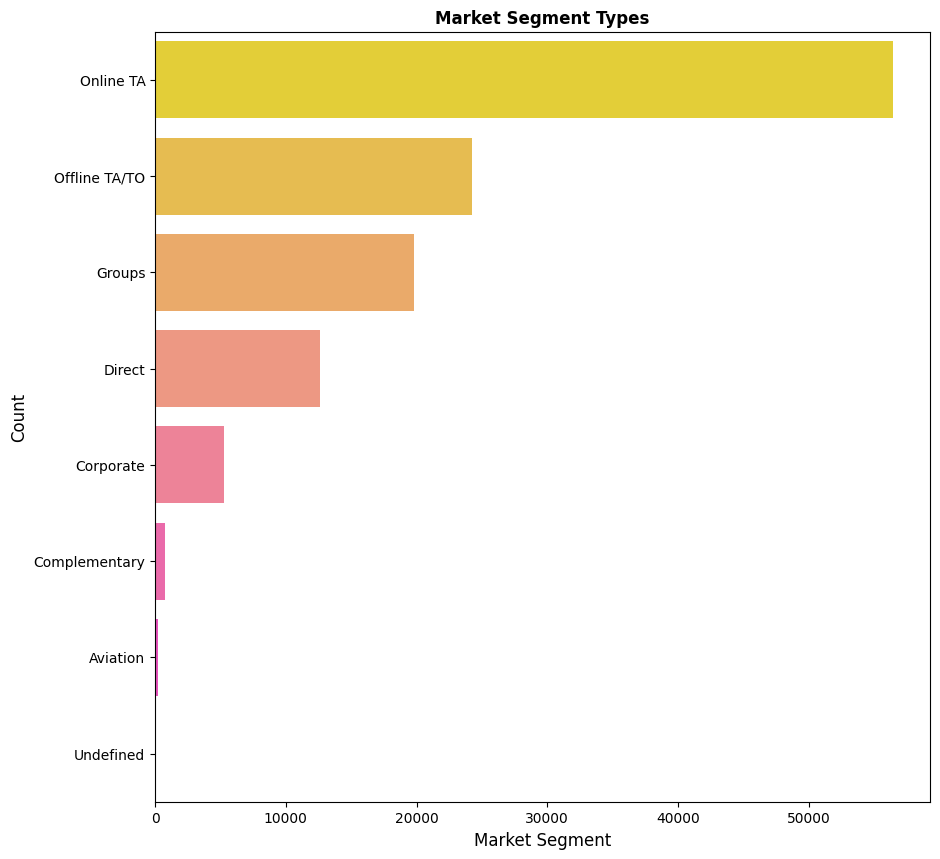

In [ ]:
# `Market_segment` feature exploration

plt.figure(figsize=(10,10))
sns.countplot(hotel_data['market_segment'], palette='spring_r',
              order=pd.value_counts(hotel_data['market_segment']).index)
plt.title('Market Segment Types', weight='bold')
plt.xlabel('Market Segment', fontsize=12)
plt.ylabel('Count', fontsize=12)

Below crosstable shows if there is any difference between assigned and reserved room types or not. The results are shown as a percentage. Average 84% of bookings keep their reserved room and the rest of the' rooms have been changed. Every row represents the reserved type and distribution over the columns shows what was the assigned room despite of reserved type.

In [ ]:
# Reserved vs Assigned room types table

pd.crosstab(index = hotel_data['reserved_room_type'],
            columns = hotel_data['assigned_room_type'],normalize='index').round(2)*100

assigned_room_type,A,B,C,D,E,F,G,H,I,K,L,P
reserved_room_type,,,,,,,,,,,,
A,86.0,1.0,2.0,9.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B,10.0,88.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
C,1.0,0.0,95.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
D,2.0,0.0,0.0,92.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
E,0.0,0.0,0.0,0.0,91.0,6.0,2.0,0.0,1.0,0.0,0.0,0.0
F,0.0,1.0,0.0,0.0,1.0,93.0,4.0,0.0,0.0,0.0,0.0,0.0
G,0.0,0.0,0.0,0.0,0.0,1.0,97.0,0.0,1.0,0.0,0.0,0.0
H,0.0,0.0,0.0,0.0,0.0,0.0,2.0,97.0,1.0,0.0,0.0,0.0
L,17.0,17.0,17.0,0.0,0.0,17.0,0.0,17.0,0.0,0.0,17.0,0.0


Another exploratory analysis made for diving deep into the relationship between ADR and arrival month and booking cancellation status. As explained in the previous graph of `arrival month`, August is the most intense month of bookings. Besides the highest `Arrival Daily Rate` has ben occurred in that month too. Except for rush months like August, July, and September, canceled bookings have higher `ADR` than not canceled bookings. Maybe this highest rate could be one of the reasons for canceled bookings.

Text(0, 0.5, 'ADR')

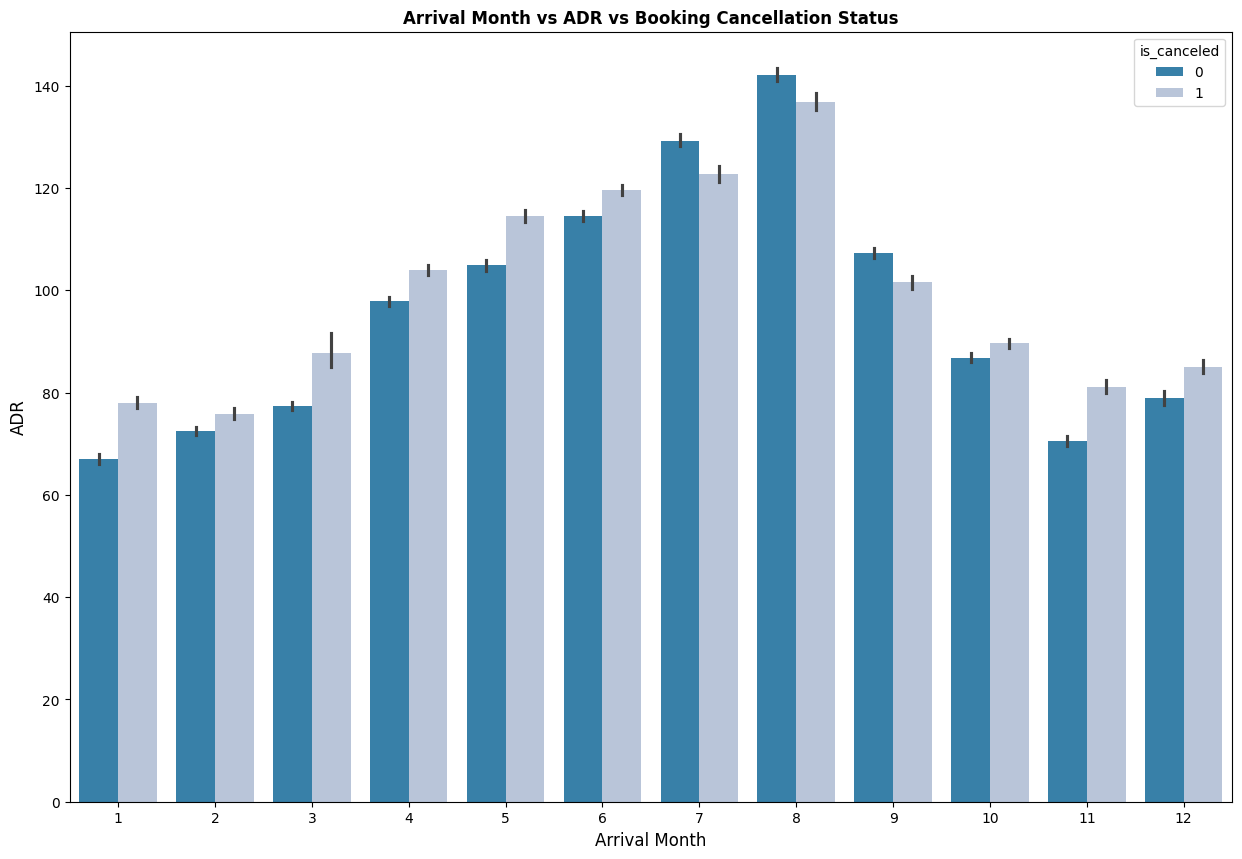

In [ ]:
# `Arrival Month` vs `ADR` vs `Booking Cancellation Status`

hotel_data['adr'] = hotel_data['adr'].astype(float)
plt.figure(figsize=(15,10))
sns.barplot(x='arrival_date_month', y='adr', hue='is_canceled', dodge=True, palette= 'PuBu_r', data=hotel_data)
plt.title('Arrival Month vs ADR vs Booking Cancellation Status', weight='bold')
plt.xlabel('Arrival Month', fontsize=12)
plt.ylabel('ADR', fontsize=12)

The below graph is about `Total Special Request` numbers. Around 55% of bookings do not have any special requests.

/tmp/ipython-input-4032169695.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='total_of_special_requests', data=hotel_data, palette = 'ocean_r')


Text(0, 0.5, 'Count')

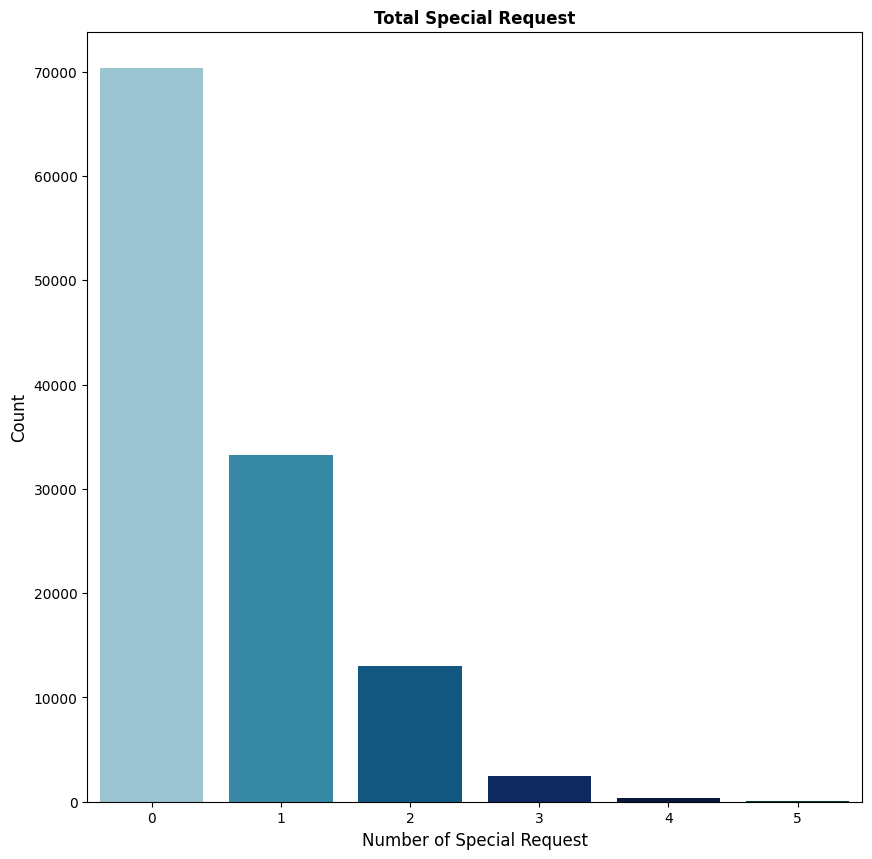

In [ ]:
# `total_of_special_requests` graph

plt.figure(figsize=(10,10))
sns.countplot(x='total_of_special_requests', data=hotel_data, palette = 'ocean_r')
plt.title('Total Special Request', weight='bold')
plt.xlabel('Number of Special Request', fontsize=12)
plt.ylabel('Count', fontsize=12)

The last graph is about the relationship between special requests and cancellation booking status. Nearly half bookings without any special requests have been canceled and another half of them have not been canceled.

Text(0, 0.5, 'Count')

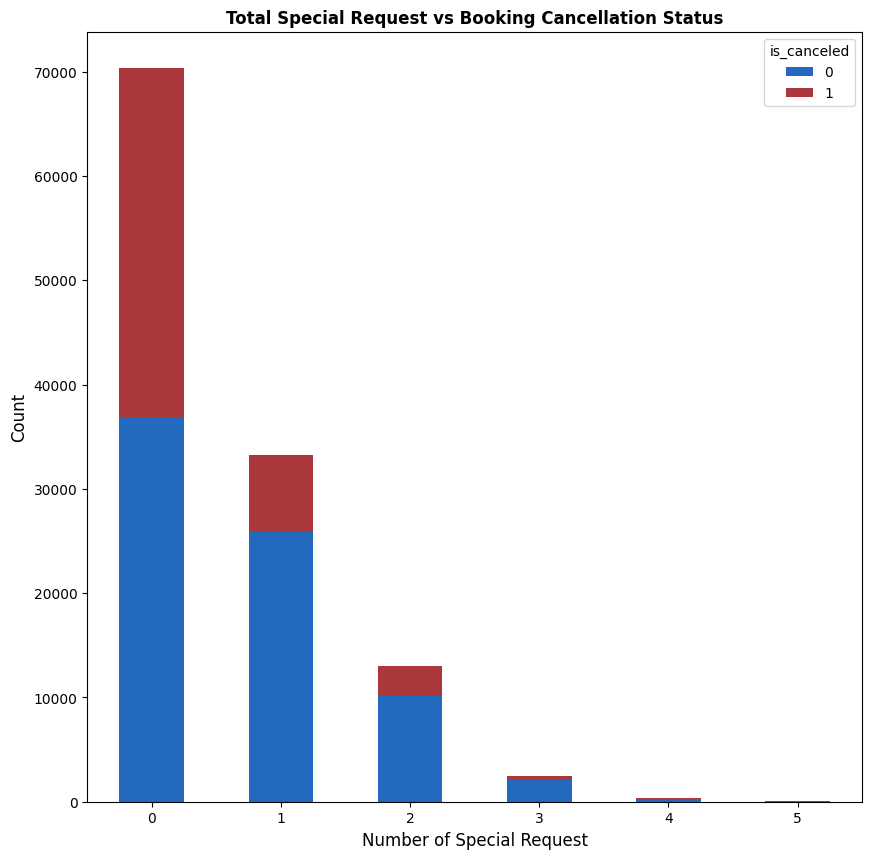

In [ ]:
# Group by `total_of_special_requests` and `is_canceled` features

group_adr_request = hotel_data.groupby([ 'total_of_special_requests', 'is_canceled']).size().unstack(fill_value=0)
group_adr_request.plot(kind='bar', stacked=True, cmap='vlag', figsize=(10,10))
plt.title('Total Special Request vs Booking Cancellation Status', weight='bold')
plt.xlabel('Number of Special Request', fontsize=12)
plt.xticks(rotation=360)
plt.ylabel('Count', fontsize=12)

## 2. Dealing with Missing Data and Correlation Matrix

이 부분에서는 먼저 결측치(missing data)를 확인합니다. 아래 코드는 각 변수(feature)의 결측치를 보여줍니다. 예를 들어, company 변수의 경우 94%가 결측치이기 때문에 이 변수는 제거됩니다.

반면, children과 all_children 변수는 결측치가 단 4개뿐입니다. 이 값들은 0으로 대체됩니다.

또 다른 결측치는 country와 agent 변수에서 발견되었습니다. country 변수의 결측치는 전체의 1% 미만이므로, **가장 빈도가 높은 값(최빈값)**으로 대체됩니다. 하지만 agent 변수의 결측치는 country보다 많기 때문에, 이 경우에는 0으로 대체됩니다.

In [ ]:
## Display sum of null data

hotel_data.isnull().sum()

,0
hotel,0
is_canceled,0
lead_time,0
arrival_date_year,0
arrival_date_month,0
arrival_date_week_number,0
arrival_date_day_of_month,0
stays_in_weekend_nights,0
stays_in_week_nights,0
adults,0


In [ ]:
# Fill missing data

hotel_data['children'] =  hotel_data['children'].fillna(0)
hotel_data['all_children'] =  hotel_data['all_children'].fillna(0)
hotel_data['country'] = hotel_data['country'].fillna(hotel_data['country'].mode().index[0])
hotel_data['agent']= hotel_data['agent'].fillna('0')
hotel_data=hotel_data.drop(['company'], axis =1)

> 결측치 처리 아쉬운점

* company: 일단 유지하면서 company_missing 같은 이진 변수 추가 → 모델링 단계에서 유용할 수 있었음.
* 단체 예약은 특히 예약 채널과 연관이 있을 수 있음.
* but 모델링할 때는 다중공선성이 발생할 수 있기에 지우는 게 맞는듯

In [ ]:
# Change data structure

hotel_data['agent']= hotel_data['agent'].astype(int)
hotel_data['country']= hotel_data['country'].astype(str)

Another part is analyzing categorical features. Categorical labels converted into numerical form. This will help to be more understandable and implementable into machine learning algorithms. Some features are not ordinal such as `country`. In that case, *One-Hot Encoding* could be chosen. Due to the high number of categories, this method could incur higher computational cost. To help reducing that, Label Encoding method will be used.

In [ ]:
#Using Label Encoder method for categorical features

labelencoder = LabelEncoder()
hotel_data['hotel'] = labelencoder.fit_transform(hotel_data['hotel'])
hotel_data['arrival_date_month'] = labelencoder.fit_transform(hotel_data['arrival_date_month'])
hotel_data['meal'] = labelencoder.fit_transform(hotel_data['meal'])
hotel_data['country'] = labelencoder.fit_transform(hotel_data['country'])
hotel_data['market_segment']= labelencoder.fit_transform(hotel_data['market_segment'])
hotel_data['distribution_channel']=labelencoder.fit_transform(hotel_data['distribution_channel'])
hotel_data['is_repeated_guest'] = labelencoder.fit_transform(hotel_data['is_repeated_guest'])
hotel_data['reserved_room_type'] = labelencoder.fit_transform(hotel_data['reserved_room_type'])
hotel_data['assigned_room_type'] = labelencoder.fit_transform(hotel_data['assigned_room_type'])
hotel_data['deposit_type'] = labelencoder.fit_transform(hotel_data['deposit_type'])
hotel_data['agent'] = labelencoder.fit_transform(hotel_data['agent'])
hotel_data['customer_type'] = labelencoder.fit_transform(hotel_data['customer_type'])
hotel_data['reservation_status'] = labelencoder.fit_transform(hotel_data['reservation_status'])
hotel_data['weekend_or_weekday'] = labelencoder.fit_transform(hotel_data['weekend_or_weekday'])

After encoding the categorical data, two data frames will be created. One data frame has only categorical data and another has numerical data. These two different data frames will be used to create a correlation matrix. *Spearman* method will be used for categorical data correlation matrix and *Pearson* method will be used for numerical one.

In [ ]:
#Create new dataframe for categorical data

hotel_data_categorical = hotel_data[['hotel','is_canceled','arrival_date_month','meal',
                                     'country','market_segment','distribution_channel',
                                     'is_repeated_guest', 'reserved_room_type',
                                     'assigned_room_type','deposit_type','agent',
                                     'customer_type','reservation_status',
                                     'weekend_or_weekday']]
hotel_data_categorical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype
---  ------                --------------   -----
 0   hotel                 119390 non-null  int64
 1   is_canceled           119390 non-null  int64
 2   arrival_date_month    119390 non-null  int64
 3   meal                  119390 non-null  int64
 4   country               119390 non-null  int64
 5   market_segment        119390 non-null  int64
 6   distribution_channel  119390 non-null  int64
 7   is_repeated_guest     119390 non-null  int64
 8   reserved_room_type    119390 non-null  int64
 9   assigned_room_type    119390 non-null  int64
 10  deposit_type          119390 non-null  int64
 11  agent                 119390 non-null  int64
 12  customer_type         119390 non-null  int64
 13  reservation_status    119390 non-null  int64
 14  weekend_or_weekday    119390 non-null  int64
dtypes: int64(15)
memory usage: 13.7 MB

In [ ]:
#Create new dataframe for numerical data

hotel_data_numerical= hotel_data.drop(['hotel','is_canceled', 'arrival_date_month','meal',
                                       'country','market_segment','distribution_channel',
                                       'is_repeated_guest', 'reserved_room_type',
                                       'assigned_room_type','deposit_type','agent',
                                       'customer_type','reservation_status',
                                       'weekend_or_weekday'], axis = 1)
hotel_data_numerical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 18 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   lead_time                       119390 non-null  int64  
 1   arrival_date_year               119390 non-null  int64  
 2   arrival_date_week_number        119390 non-null  int64  
 3   arrival_date_day_of_month       119390 non-null  int64  
 4   stays_in_weekend_nights         119390 non-null  int64  
 5   stays_in_week_nights            119390 non-null  int64  
 6   adults                          119390 non-null  int64  
 7   children                        119390 non-null  float64
 8   babies                          119390 non-null  int64  
 9   previous_cancellations          119390 non-null  int64  
 10  previous_bookings_not_canceled  119390 non-null  int64  
 11  booking_changes                 119390 non-null  int64  
 12  days_in_waiting_

Text(0.5, 1.0, 'Correlation Matrix Spearman Method- Categorical Data ')

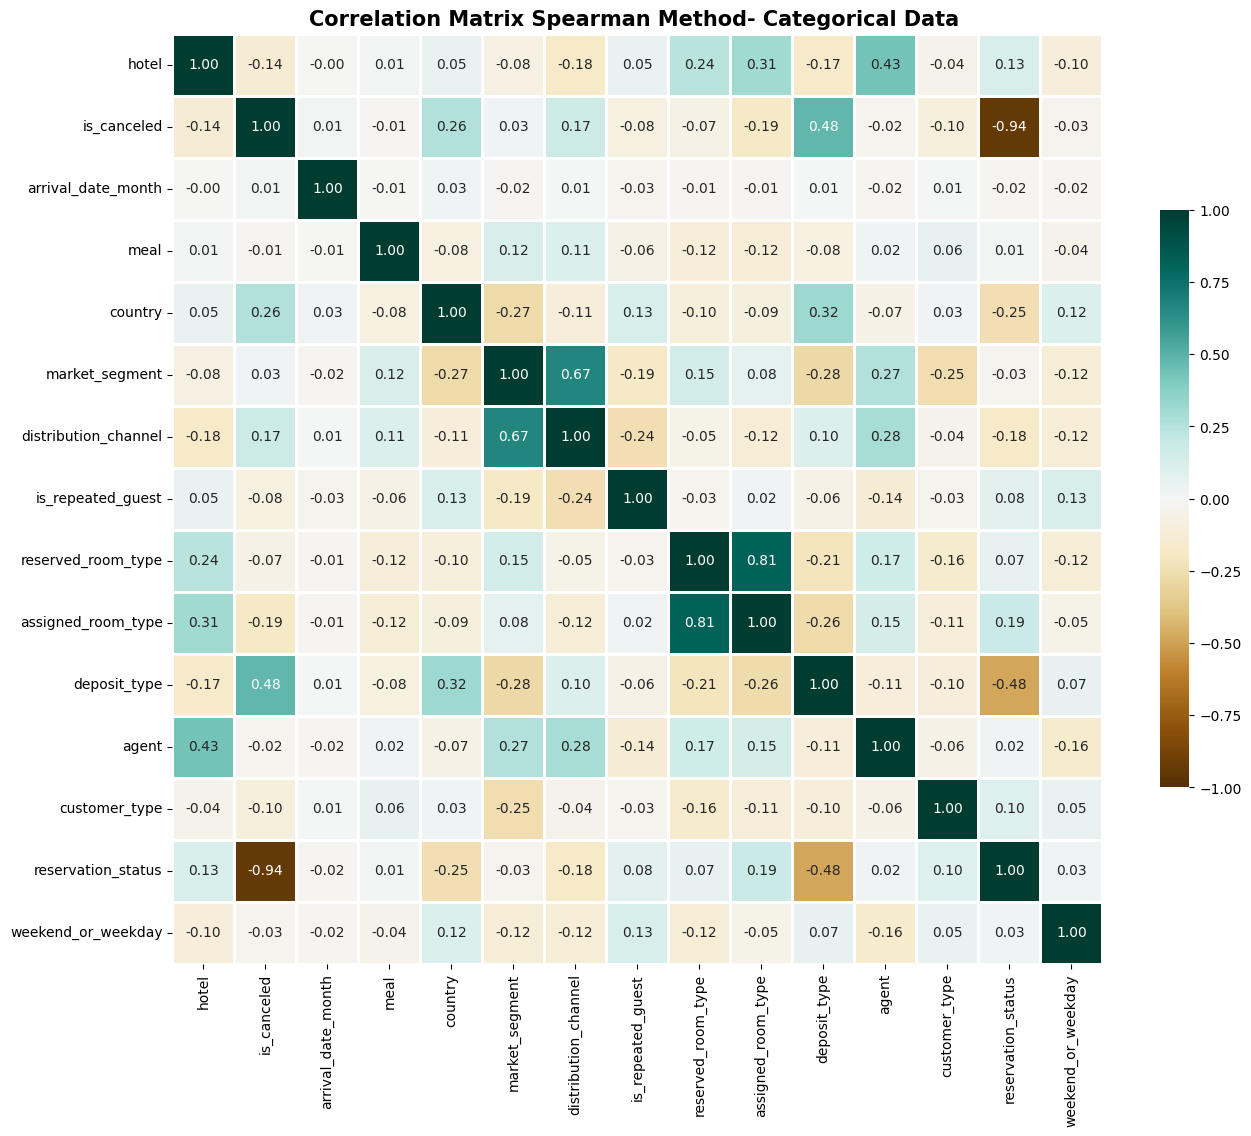

In [ ]:
# Correlation Matrix with Spearman method

plt.figure(figsize=(15,15))
corr_categorical=hotel_data_categorical.corr(method='spearman')
mask_categorical = np.triu(np.ones_like(corr_categorical, dtype=np.bool))
sns.heatmap(corr_categorical, annot=True, fmt=".2f", cmap='BrBG', vmin=-1, vmax=1, center= 0,
            square=True, linewidths=2, cbar_kws={"shrink": .5}).set(ylim=(15, 0))
plt.title("Correlation Matrix Spearman Method- Categorical Data ",size=15, weight='bold')

> 범주형 변수 상관관계

* 명목형 변수 (특히 원핫 인코딩한 경우) → Spearman은 별 의미 없음 ❌
* → 대신 Cramér’s V, 카이제곱 검정, Mutual Information 같은 범주형 전용 방법을 쓰는 게 더 적합.

Text(0.5, 1.0, 'Correlation Matrix Pearson Method- Numerical Data ')

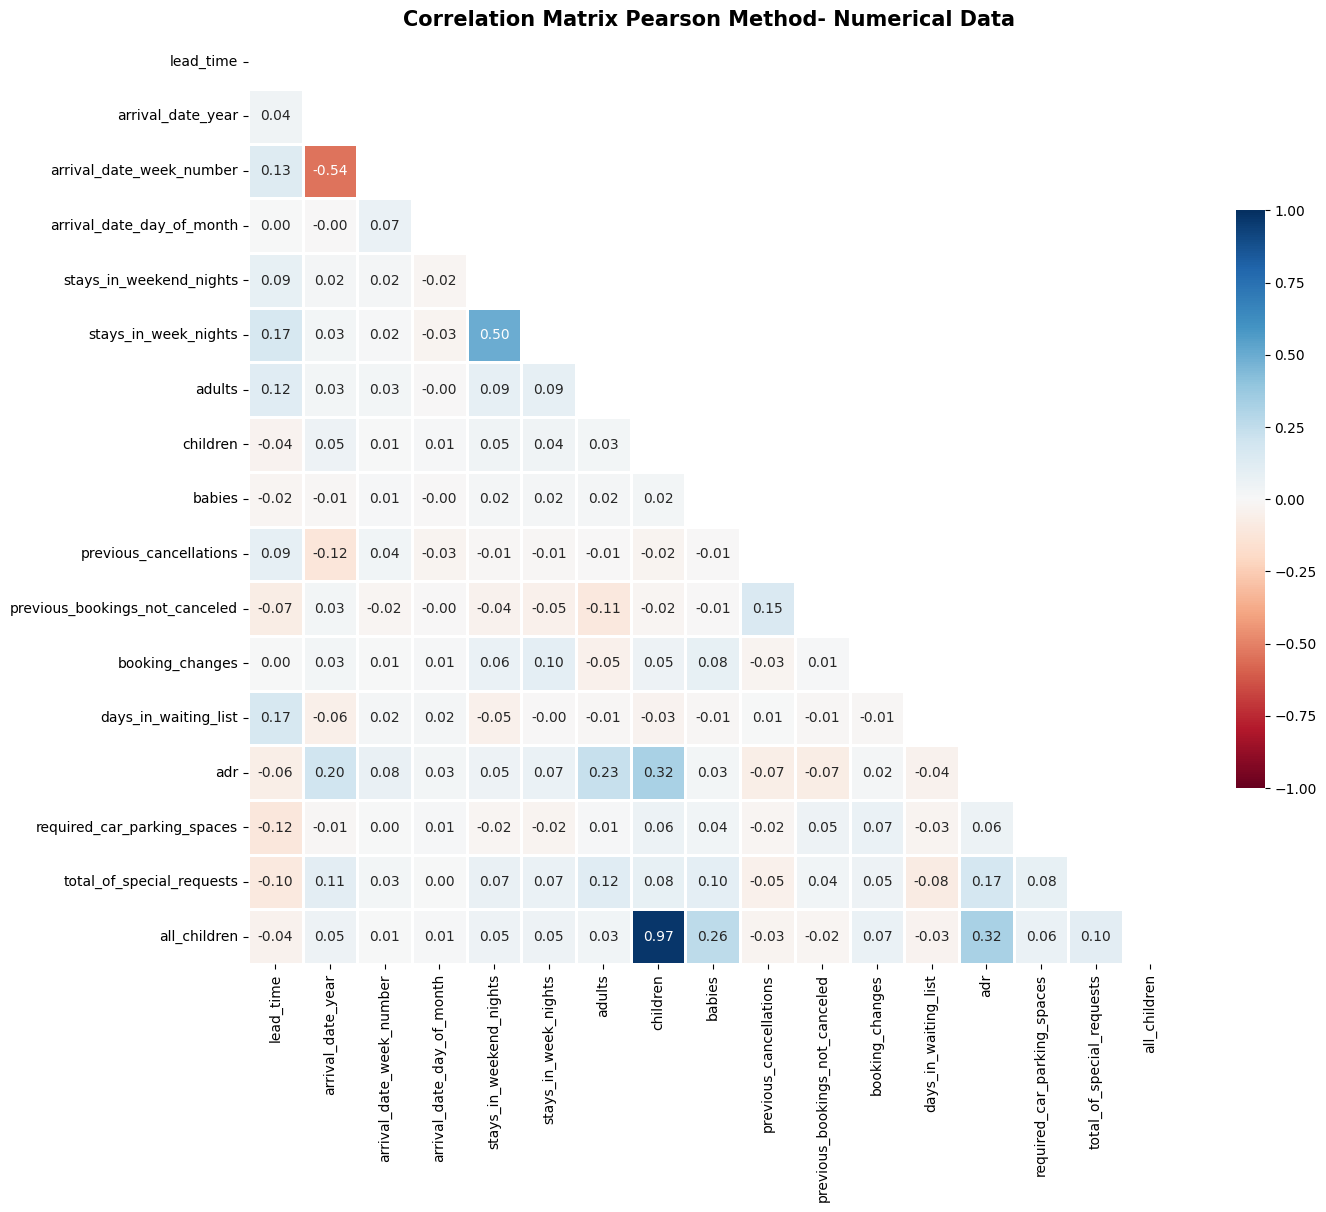

In [ ]:
# Correlation Matrix with pearson method

plt.figure(figsize=(15,15))
hotel_data_numerical = hotel_data_numerical.drop(['reservation_status_date'], axis=1)
corr_numerical=hotel_data_numerical.corr(method='pearson')
mask_numerical = np.triu(np.ones_like(corr_numerical, dtype=np.bool))
sns.heatmap(corr_numerical, annot=True, fmt=".2f", cmap='RdBu', mask= mask_numerical, vmin=-1, vmax=1, center= 0,
            square=True, linewidths=2, cbar_kws={"shrink": .5}).set(ylim=(17, 0))
plt.title("Correlation Matrix Pearson Method- Numerical Data ",size=15, weight='bold')

> 새로운 시각화: 상삼각 행렬
* sns.heatmap(..., mask=mask_numerical) 은 mask=True인 부분을 가려서 출력하지 않음.
따라서 윗부분(True 부분)이 가려지고, 아랫부분(False 부분)만 보이는 것

In [ ]:
# Finding high correlated features

corr_mask_categorical = corr_categorical.mask(mask_categorical)
corr_values_categorical = [c for c in corr_mask_categorical.columns if any (corr_mask_categorical[c] > 0.90)]
corr_mask_numerical = corr_numerical.mask(mask_numerical)
corr_values_numerical = [c for c in corr_mask_numerical.columns if any (corr_mask_numerical[c] > 0.90)]
print(corr_values_categorical, corr_values_numerical)

[] ['children']


위의 상관계수 행렬은 변수들 간의 양(+)·음(–)의 관계를 보여줍니다. 그 중에서도 두 개의 히트맵에서 reservation_status 변수가 특히 주목되는데, 이는 is_canceled 변수와 음의 상관관계를 보이기 때문입니다. 아래 표는 이 관계를 자세히 보여줍니다. 이러한 높은 상관관계는 잘못된 예측이나 과적합(overfitting)을 초래할 수 있습니다. 이를 방지하기 위해 reservation_status 변수는 제거됩니다.

한편, children과 all_children 변수 사이에도 높은 상관관계가 나타납니다. 이는 all_children 변수가 children과 babies 변수를 합쳐서 구성되었기 때문입니다. 따라서 children 변수 역시 제거됩니다.

마지막으로, reservation_status_date 변수는 날짜형(date type) 데이터를 포함하고 있으며, 다른 타입으로 변환하기 어렵기 때문에 이 변수 역시 제거됩니다.

In [ ]:
# `reservation_status` vs `is_canceled` table

pd.crosstab(columns = hotel_data['reservation_status'], index = hotel_data['is_canceled'],
           margins=True, margins_name = 'Total')

reservation_status,0,1,2,Total
is_canceled,,,,
0,0,75166,0,75166
1,43017,0,1207,44224
Total,43017,75166,1207,119390


In [ ]:
#Dropping some features from data

hotel_data = hotel_data.drop(['reservation_status', 'children', 'reservation_status_date'], axis=1)

In [ ]:
#Copying data to used next parts

hotel_data_model = hotel_data

## 3. Hyperparameter Tunning and Feature Importance

이 부분에서는 여러 트리 기반 머신러닝 알고리즘에 대해 그리드 서치(Grid Search) 알고리즘을 활용하여 최적의 하이퍼파라미터를 탐색합니다. 하이퍼파라미터 튜닝은 학습 과정에서 예측을 더 정확하게 할 수 있도록 도와주며, 따라서 학습을 시작하기 전에 하이퍼파라미터를 고정하게 됩니다.

또 하나 중요한 작업은 Extreme Gradient Boosting(XGBoost) 알고리즘을 이용해 Permutation Feature Importance 그래프를 작성하는 것입니다. 이 기법은 특징(feature)들의 중요도를 계산하며, 성능 평가지표로는 정확도(accuracy score)가 기준으로 선택됩니다. 이 그래프는 어떤 특징들이 예측에 기여하는지를 이해하게 해주고, 데이터셋에 대한 인사이트를 제공하며, 만약 중요하지 않은 특징이 있다면 이를 발견하는 데 도움을 줍니다.

In [ ]:
# Seperate target variable


hotel_data_tunning = hotel_data
y = hotel_data_tunning.iloc[:,1]
X = pd.concat([hotel_data_tunning.iloc[:,0],hotel_data_tunning.iloc[:,2:30]], axis=1)

> 하이퍼파라미터 튜닝


```
parameters = {
  'n_estimators' : [100, 250, 500],     # 트리 개수
  'learning_rate' : [0.01, 0.1],        # 학습률 (작을수록 천천히 학습, 과적합 방지)
  'subsample' : [0.5, 1.0],             # 각 트리 학습 시 사용할 데이터 샘플 비율
  'max_depth' : [3, 5, 7],              # 트리 깊이 (클수록 복잡한 모델)
  'criterion' : ['giny', 'entropy'],    # 분할 기준 (⚠️ XGBClassifier에는 없음, DecisionTree 계열 파라미터)
  'objective':['binary:logistic']       # 이진 분류용 로지스틱 손실 함수
}
```



> Grid search 동작 원리



```
사람이 여러 후보 값들을 미리 정함

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1]
}


→ 가능한 조합: 3(depth) × 2(learning_rate) = 6가지

모든 조합을 전부 시도 (Brute Force 방식)

각 조합으로 모델을 학습

교차검증(Cross Validation)을 통해 성능 측정

가장 성능이 좋은 조합을 선택

예: F1-score, Accuracy, AUC 같은 지표 기준
```



In [ ]:
## Finding parameters for XGBoost model

# model = XGBClassifier()
# parameters = {
# 'n_estimators' : [100,250,500],
# 'learning_rate' : [0.01, 0.1],
# 'subsample' :[0.5, 1.0],
# 'max_depth' : [3,5,7],
# 'criterion' : ['giny','entropy'],
# 'objective':['binary:logistic'],
# }

# grid_search = GridSearchCV(estimator=model, param_grid=parameters,
#                           cv=5, scoring='f1', verbose=True, n_jobs=-1)
# grid_search.fit(X, y)
# print(grid_search.best_score_)
# print(grid_search.best_params_)

In [ ]:
## Finding parameters for RF model

# model_rfc_gs = RandomForestClassifier()
# parameters_rfc = {
# 'n_estimators' : [100,200,500],
# 'min_samples_split' : [2,4,6,8],
# 'min_samples_leaf': [1,2,4,6]
# }

# grid_search_rfc = GridSearchCV(estimator=model_rfc_gs, param_grid=parameters_rfc,
#                           cv=5, scoring='f1', verbose=True, n_jobs=-1)
# grid_search_rfc.fit(X, y)
# grid_search_rfc.best_params_

In [ ]:
## Finding parameters for Extra Tree Classifier

# model_etc_gs = ExtraTreesClassifier()
# parameters_etc = {
# 'n_estimators' : [100,250,500],
# 'min_samples_split' : [2,4,6,8],
# 'min_samples_leaf': [1,3,5,7]
# }

# grid_search_etc = GridSearchCV(estimator=model_etc_gs, param_grid=parameters_etc,
#                           cv=5, scoring='f1', verbose=True, n_jobs=-1)
# grid_search_etc.fit(X, y)
# grid_search_etc.best_params_

In [ ]:
## Finding parameters for Decision Tree

# model_dtc_gs = DecisionTreeClassifier()
# parameters_dtc = {
# 'criterion' : ['gini', 'entropy'],
# 'min_samples_split' : [2,4,6,8],
# 'min_samples_leaf': [1,2,3,4,5],
# 'max_features' : ['auto', 'sqrt']
# }

# grid_search_dtc = GridSearchCV(estimator=model_dtc_gs, param_grid=parameters_dtc,
#                           cv=5, scoring='f1', verbose=True, n_jobs =-1)
# grid_search_dtc.fit(X, y)
# grid_search_dtc.best_params_

In [ ]:
# Permutation Importance graph with XGB Classifier algorithm.

params = {
    'criterion': 'giny',
    'learning_rate': 0.01,
    'max_depth': 5,
    'n_estimators': 100,
    'objective': 'binary:logistic',
}
model = XGBClassifier(parameters=params)
# fit the model
model.fit(X, y)
# perform permutation importance
result = permutation_importance(model, X, y, scoring='accuracy', n_repeats = 5, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [13:21:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "parameters" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


> 중요도 정렬 코드


```
sorted_idx = result.importances_mean.argsort()
result.importances_mean → 각 feature 중요도의 평균값

.argsort() → 중요도 낮은 순으로 feature 인덱스 정렬
```


> permutation importance

Permutation Feature Importance (특성 중요도 측정 기법)

동작 원리:

특정 feature 값을 랜덤으로 섞음 → 원래 규칙성 깨뜨림

모델 성능이 얼마나 떨어지는지 확인

많이 떨어질수록 해당 feature가 중요한 변수

> 왜 씀?

방금 본 Permutation Feature Importance는 단순히 “모델이 학습한 중요도”를 보는 게 아니라, 실제로 모델의 예측 정확도에 기여하는 정도를 확인하기 위해 씁니다.

XGBoost나 RandomForest에는 자체 feature importance가 있지만, 보통 “트리 분할 횟수” 기준이라서 해석이 왜곡될 수 있음.

Permutation Importance는 “그 feature 없애봤을 때 성능이 얼마나 떨어지나” → 더 현실적인 중요도.

In [ ]:
# Feature scores table

for i,v in enumerate(sorted_idx):
    print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 9.00000
Feature: 1, Score: 0.00000
Feature: 2, Score: 27.00000
Feature: 3, Score: 6.00000
Feature: 4, Score: 28.00000
Feature: 5, Score: 22.00000
Feature: 6, Score: 14.00000
Feature: 7, Score: 8.00000
Feature: 8, Score: 13.00000
Feature: 9, Score: 3.00000
Feature: 10, Score: 7.00000
Feature: 11, Score: 10.00000
Feature: 12, Score: 5.00000
Feature: 13, Score: 16.00000
Feature: 14, Score: 19.00000
Feature: 15, Score: 24.00000
Feature: 16, Score: 4.00000
Feature: 17, Score: 25.00000
Feature: 18, Score: 23.00000
Feature: 19, Score: 2.00000
Feature: 20, Score: 15.00000
Feature: 21, Score: 12.00000
Feature: 22, Score: 17.00000
Feature: 23, Score: 18.00000
Feature: 24, Score: 26.00000
Feature: 25, Score: 1.00000
Feature: 26, Score: 21.00000
Feature: 27, Score: 20.00000
Feature: 28, Score: 11.00000


> 부스팅 기법 비교

| 구분                 | AdaBoost             | XGBoost                    |
| ------------------ | -------------------- | -------------------------- |
| 핵심 아이디어            | 잘못 분류된 샘플에 가중치 ↑     | 잔차(residual)를 줄이는 방향으로 최적화 |
| 수학적 기초             | 가중치 업데이트 중심          | 경사하강법(Gradient Descent)    |
| 규제(Regularization) | 없음                   | L1, L2 정규화 지원 (과적합 방지)     |
| 속도                 | 상대적으로 느림             | 병렬 처리 지원 → 빠름              |
| 이상치(outlier)       | 민감 (오류 샘플에 가중치 ↑ 때문) | 상대적으로 덜 민감                 |
| 활용도                | 기초적인 부스팅 모델          | Kaggle/현업에서 자주 쓰이는 강력한 모델  |


/tmp/ipython-input-3090481930.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(result.importances[sorted_idx].T,


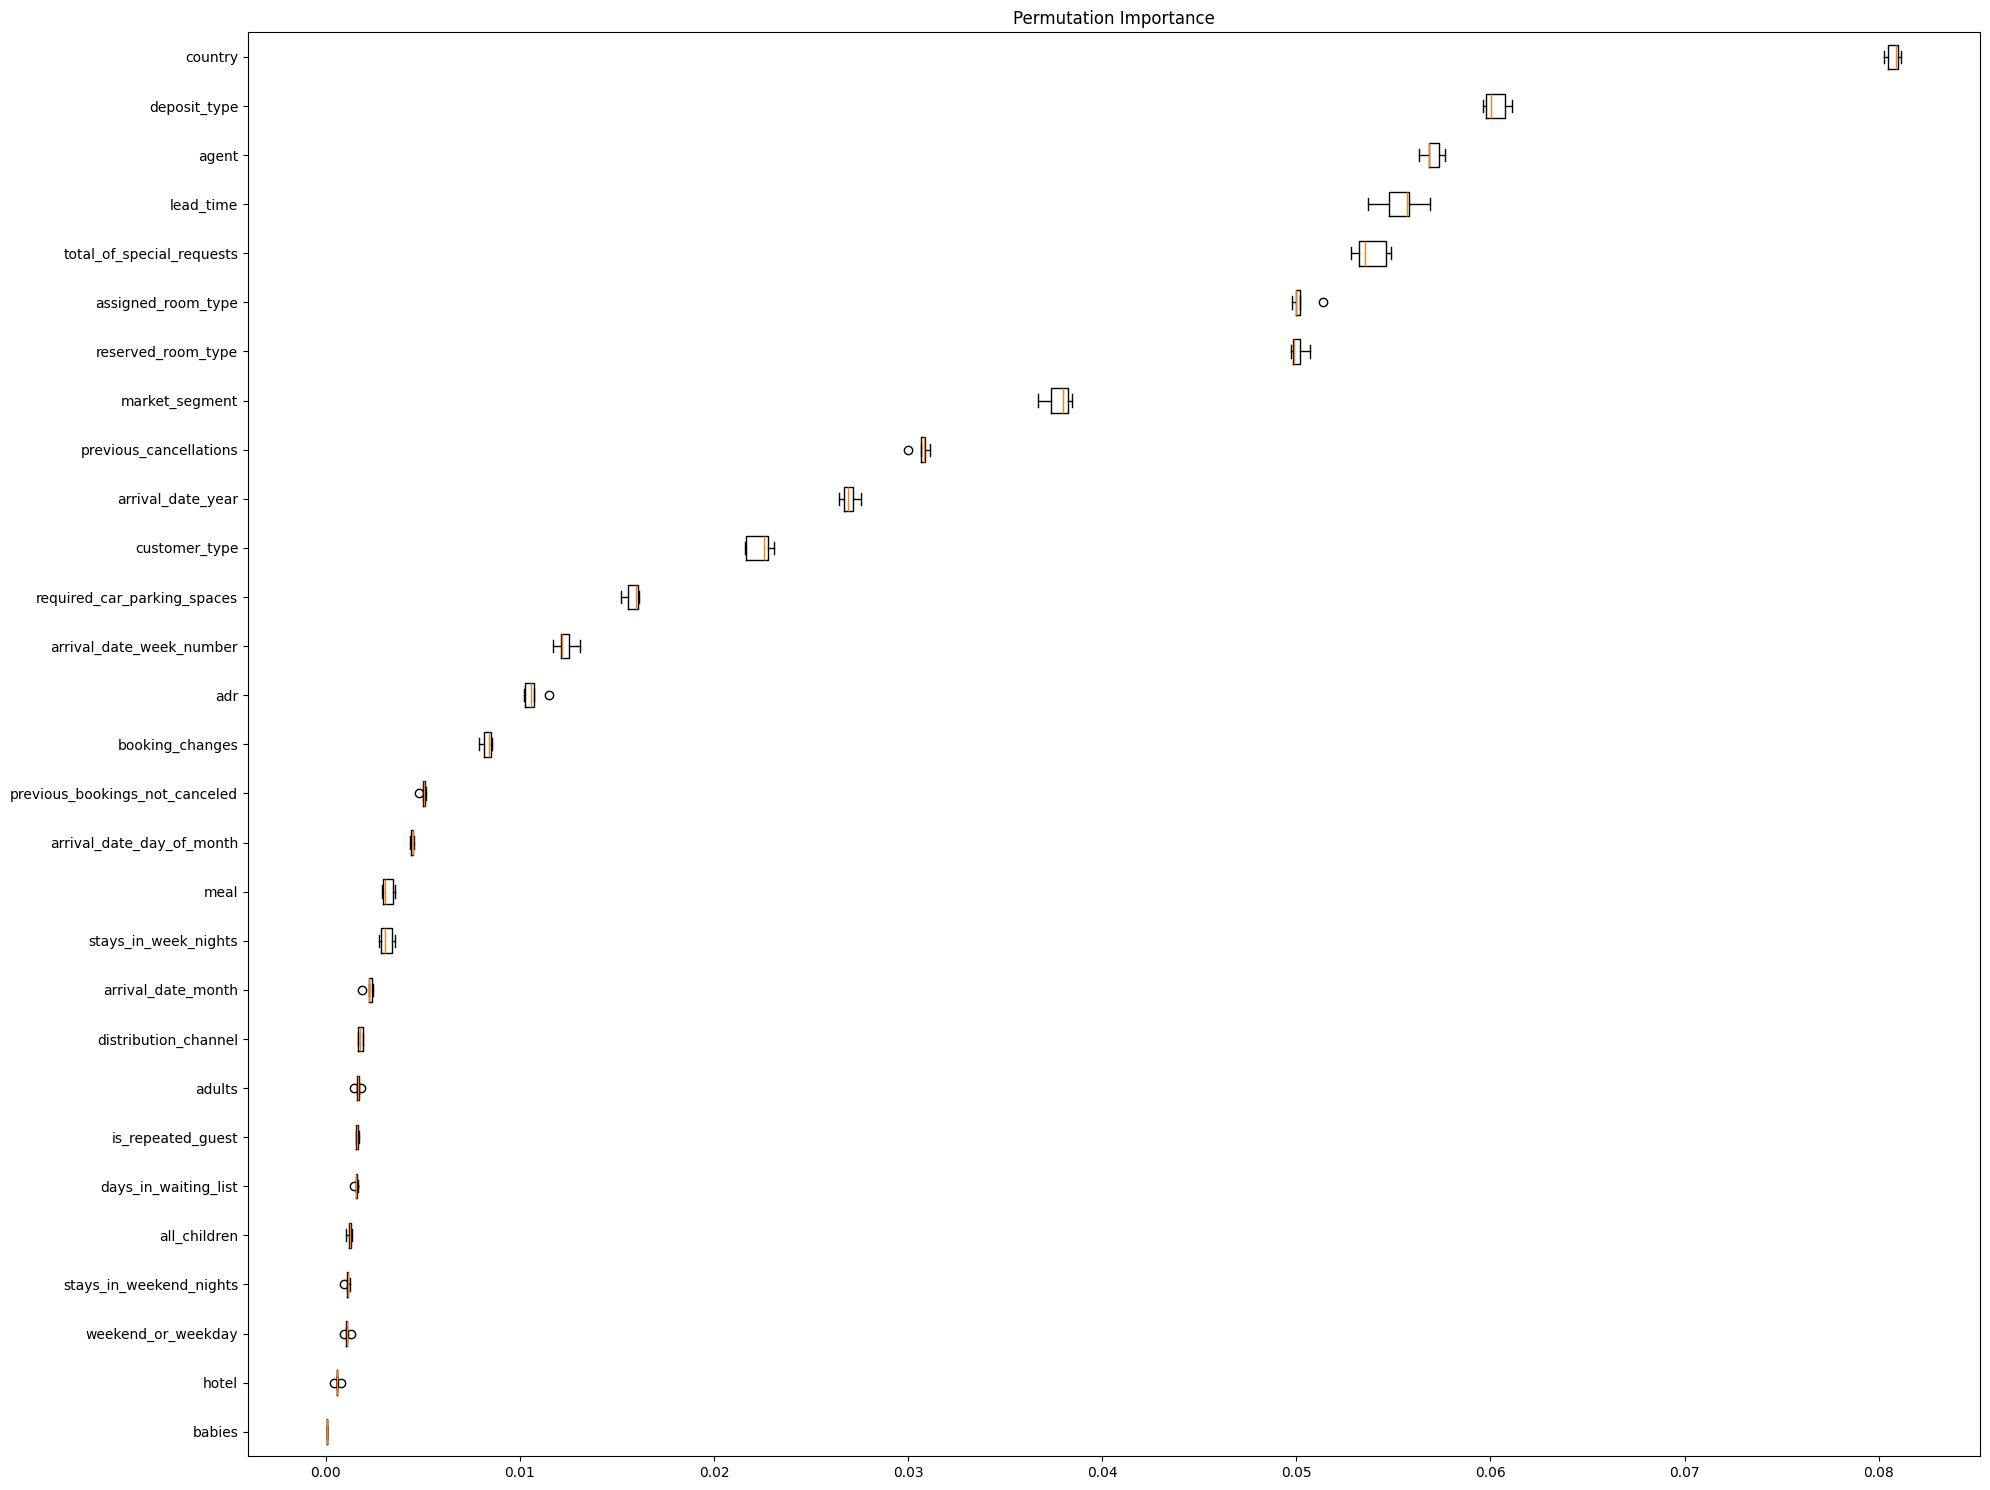

In [ ]:
#Permutation Importance graph

fig, ax = plt.subplots(figsize=(20,15))

ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X.columns[sorted_idx])
ax.set_title("Permutation Importance")
fig.tight_layout()
plt.show()

> 해석

방법: Permutation Importance

원리:

특정 feature 값을 무작위로 섞음 → 규칙성 깨뜨림

모델 성능(정확도)이 얼마나 떨어지는지 확인

성능 하락이 클수록 중요한 feature

장점: 모델 내부 가중치에 의존하지 않고, 실제로 성능에 기여하는 정도를 직접 측정

단점: 계산량 많음, 데이터 분포/샘플 수에 민감

👉 그래서 그래프에선 country, deposit_type, agent, lead_time, special_requests 같은 변수들이 중요하게 나왔음

The above graph shows the feature importance of the features. according to that, 1 out of 29 features are not being important to prediction which is `babies`. It will eliminated.

In [ ]:
# Drop `baby` feature from data

hotel_data_model = hotel_data_model.drop(['babies'], axis=1)

## 4. Model Building

이 부분에서는 모델 구축을 위해 여러 트리 기반 알고리즘이 사용되었습니다. 사용된 알고리즘은 의사결정나무(Decision Tree), 랜덤 포레스트(Random Forest), 엑스트라 트리 분류기(Extra Trees Classifier), 그리고 **익스트림 그래디언트 부스팅(XGBoost)**입니다. 이 중에서 랜덤 포레스트와 엑스트라 트리 분류기는 배깅(bagging) 알고리즘으로 선택되었고, XGBoost는 부스팅(boosting) 알고리즘으로 선택되었습니다. 또한 의사결정나무 알고리즘은 단일 트리 기반 알고리즘으로 선택되었습니다.

모델 구축 전에 데이터는 훈련용 70%, 테스트용 30%의 비율로 분할됩니다. 이후 X_train과 X_test 데이터는 표준화(Standard Scaler) 기법을 이용해 정규화됩니다. 그 다음 단계에서는 층화 교차검증(Stratified K-Fold Cross Validation) 기법이 리샘플링을 위해 사용됩니다. 교차검증은 과적합을 피하기 위한 중요한 기법이며, Stratified K-Fold는 데이터의 클래스 분포를 유지하면서 학습/검증 세트를 나눌 수 있도록 인덱스를 제공합니다.

In [ ]:
# Seperate target variable for model building

y_model = hotel_data_model.iloc[:,1]
X_model = pd.concat([hotel_data_tunning.iloc[:,0],hotel_data_tunning.iloc[:,2:30]], axis=1)
y_model.describe()

,is_canceled
count,119390.000000
mean,0.370416
std,0.482918
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [ ]:
# Split to train and test with 70-30 ratio

X_train, X_test, y_train, y_test = train_test_split(X_model, y_model, test_size=0.3, random_state=42, stratify = y)

# stratify=y → 타깃 변수(y)의 클래스 비율을 train/test에 동일하게 유지

> standardscaler

* 보통 전처리 다하고 학습/훈련 데이터 나눈 후 조정 (맨날 헷갈림)
* train으로 평균/표준편차 구해서 → test 데이터도 같은 값으로 바꿔줌.

In [ ]:
# Implement standart scaler method
## 트레인/테스트 독립변수들 스케일링

standardScalerX = StandardScaler()
X_train = standardScalerX.fit_transform(X_train)
X_test = standardScalerX.transform(X_test)

In [ ]:
# Stratified K-Fold Cross Validation Method

kfold_cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

for train_index, test_index in kfold_cv.split(X_model,y_model):
    X_train, X_test = X_model.iloc[train_index], X_model.iloc[test_index]
    y_train, y_test = y_model.iloc[train_index], y_model.iloc[test_index]

> stratifiedkfold
* 전체 데이터를 5등분해서,매 반복마다 4개 폴드로 학습(train), 남은 1개 폴드로 검증(test)
이 과정을 5번 반복하면서 모든 데이터가 한 번씩은 검증 세트에 들어감

In [ ]:
# Decision Tree Model Building

dtc_model = DecisionTreeClassifier(criterion= 'gini', min_samples_split=8,
                                  min_samples_leaf = 4, max_features = 'sqrt')
# fit the model
dtc_model.fit(X_train, y_train)

#Predict Model
predict_dtc = dtc_model.predict(X_test)

In [ ]:
# Random Forest Model Building

rf_model = RandomForestClassifier(min_samples_leaf = 6, min_samples_split=6,
                                  n_estimators = 100)

# fit the model
estimator= rf_model.fit(X_train, y_train)
#Predict Model
predict_rf = rf_model.predict(X_test)

In [ ]:
# Extra Treees Classsifier Model Building

etc_model = ExtraTreesClassifier(min_samples_leaf = 7, min_samples_split=2,
                                  n_estimators = 100)
# fit the model
etc_model.fit(X_train, y_train)

#Predict Model
predict_etc = etc_model.predict(X_test)

In [ ]:
# Extreme Gradient Boosting Model Building

xgb_model = XGBClassifier(criterion = 'giny', learning_rate = 0.01, max_depth = 5, n_estimators = 100,
                          objective ='binary:logistic', subsample = 1.0)
# fit the model
xgb_model.fit(X_train, y_train)
#Predict Model
predict_xgb = xgb_model.predict(X_test)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [14:34:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "criterion" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


## 5. Classification Reports and Classification Matrix

The last part is comparison of classification reports of ML models.


First comparison the accuracy results.
* Accuracy is a ratio of correct predictions to the total predictions.  
Its formula is $(TP+TN) / (TP+FP+FN+TN)$

According to that, *Random Forest* have the highest correct prediction with 88%.
Another performance metrics explained below:

* Precision: It is the ratio of correctly predicted observation to the total positive predicted observation.
Its formula is $TP / (TP+FP)$
* Recall: It is the ratio of correctly predicted positive observations to the actual positive observations.
Its formula is $TP / (TP+FN)$

*Random Forest*  and the *Extra Tree Classifier* share the highest precision ratios. It means that both models predicted around 88% of all the positive labels correctly.  On the other hand *Random Forest* has the highest recall ratio. It means that this model predicted 79% of actual positive observations correctly.

In [ ]:
# Classification Reports

print("RF", classification_report(y_test, predict_rf))
print("DTC",classification_report(y_test, predict_dtc))
print("ETC", classification_report(y_test, predict_etc))
print("XGB", classification_report(y_test, predict_xgb))

RF               precision    recall  f1-score   support

           0       0.88      0.94      0.91     15033
           1       0.88      0.79      0.83      8845

    accuracy                           0.88     23878
   macro avg       0.88      0.86      0.87     23878
weighted avg       0.88      0.88      0.88     23878

DTC               precision    recall  f1-score   support

           0       0.87      0.90      0.88     15033
           1       0.81      0.78      0.80      8845

    accuracy                           0.85     23878
   macro avg       0.84      0.84      0.84     23878
weighted avg       0.85      0.85      0.85     23878

ETC               precision    recall  f1-score   support

           0       0.85      0.95      0.90     15033
           1       0.90      0.72      0.80      8845

    accuracy                           0.87     23878
   macro avg       0.88      0.84      0.85     23878
weighted avg       0.87      0.87      0.86     23878

XGB     

> 재현율과 정확도

Precision: 취소 예측의 “정확성”
→ 모델이 취소라고 했을 때 정말 취소일 확률

Recall: 취소 예측의 “포착력”
→ 실제 취소 건을 얼마나 놓치지 않았는가

Text(792.3131313131312, 0.5, 'Actual Labels')

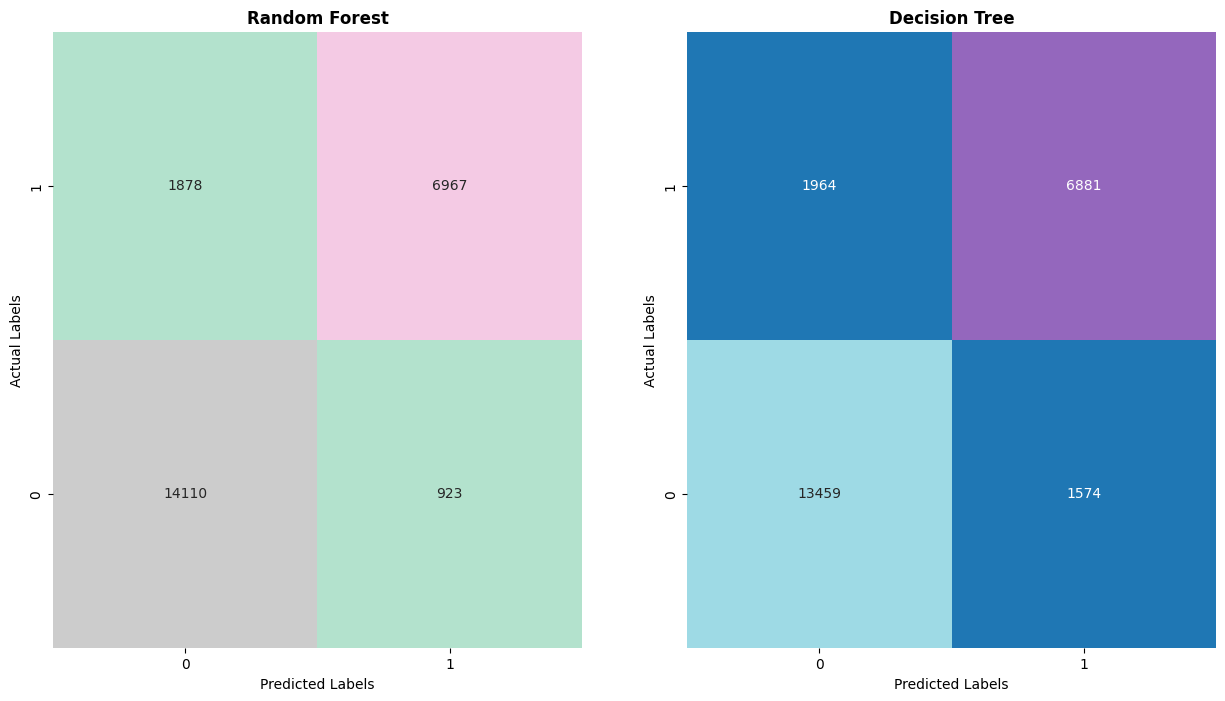

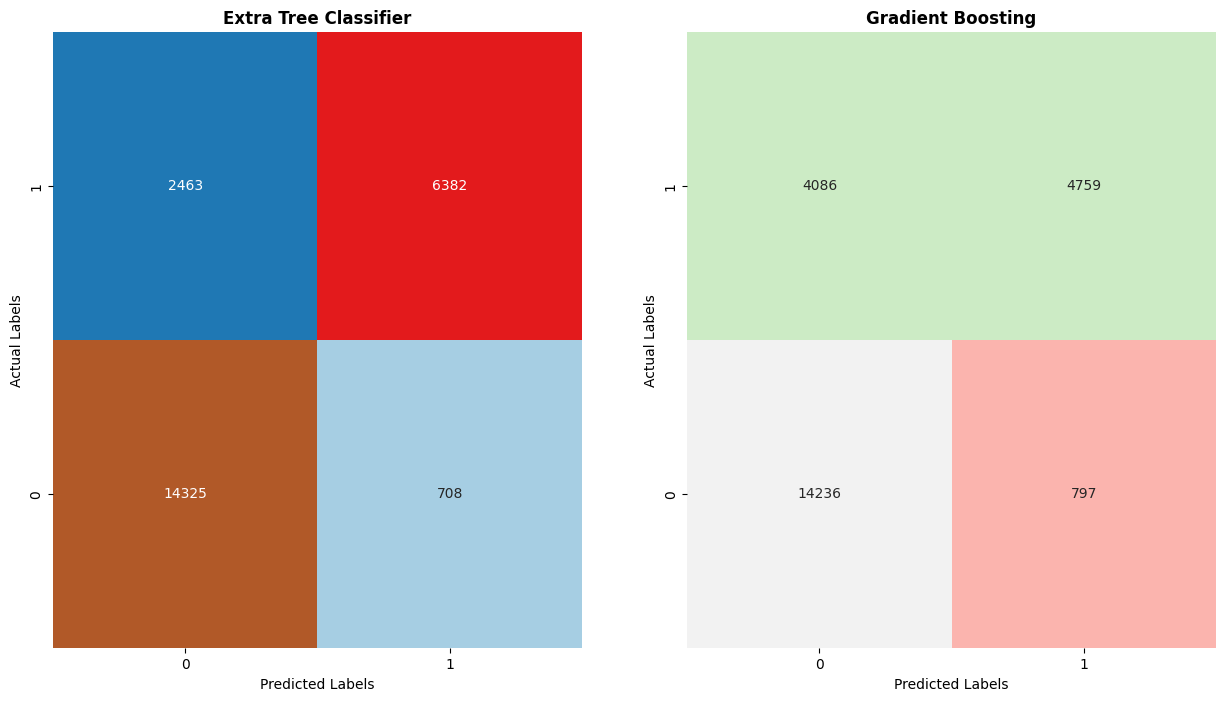

In [ ]:
# Confusion Matrix

DTC_matrix = confusion_matrix(y_test, predict_dtc)
RF_matrix = confusion_matrix(y_test, predict_rf)
ETC_matrix = confusion_matrix(y_test, predict_etc)
XGB_matrix = confusion_matrix(y_test, predict_xgb)

fig, ax = plt.subplots(1, 2, figsize=(15, 8))
sns.heatmap(RF_matrix,annot=True, fmt="d", cbar=False, cmap="Pastel2",  ax = ax[0]).set_ylim([0,2])
ax[0].set_title("Random Forest", weight='bold')
ax[0].set_xlabel('Predicted Labels')
ax[0].set_ylabel('Actual Labels')
sns.heatmap(DTC_matrix,annot=True, fmt="d" ,cbar=False, cmap="tab20", ax = ax[1]).set_ylim([0,2])
ax[1].set_title("Decision Tree", weight='bold')
ax[1].set_xlabel('Predicted Labels')
ax[1].set_ylabel('Actual Labels')

fig, axe = plt.subplots(1, 2, figsize=(15, 8))
sns.heatmap(ETC_matrix,annot=True, fmt="d", cbar=False, cmap="Paired", ax = axe[0]).set_ylim([0,2])
axe[0].set_title("Extra Tree Classifier", weight='bold')
axe[0].set_xlabel('Predicted Labels')
axe[0].set_ylabel('Actual Labels')
sns.heatmap(XGB_matrix,annot=True, fmt="d", cbar=False, cmap="Pastel1", ax = axe[1]).set_ylim([0,2])
axe[1].set_title("Gradient Boosting", weight='bold')
axe[1].set_xlabel('Predicted Labels')
axe[1].set_ylabel('Actual Labels')

**Any feedback is welcome, please be generous to share your feedbacks**

> 배깅과 부스팅

📌 배깅(Bagging) vs 부스팅(Boosting) 비교

배깅 (예: Random Forest, Extra Trees)

여러 트리를 동시에(parallel) 학습

각 트리가 독립적으로 학습되고, 마지막에 평균/투표로 합침

부스팅 (예: XGBoost, AdaBoost, LightGBM)

여러 트리를 순차적으로(sequential) 학습

ㄴ 부스팅은 최종 트리를 만들어나가는 것이고 배깅은 여러 트리들을 종합적으로 보는거네?

| 구분    | 배깅 (Random Forest) | 부스팅 (XGBoost 등)          |
| ----- | ------------------ | ------------------------ |
| 학습 방식 | 병렬 (트리 독립 학습)      | 순차 (앞 트리 오차 보완)          |
| 트리 역할 | 독립된 트리들의 집합        | 이전 트리를 개선하는 보조 트리        |
| 최종 결과 | 여러 트리의 평균/투표       | 여러 트리 합쳐서 **하나의 강력한 모델** |
| 장점    | 안정적, 과적합 적음        | 성능 매우 높음                 |
| 단점    | 성능 한계 있음           | 학습 느리고 튜닝 필요             |


> RF vs ETC

📌 Random Forest (RF)

트리마다 데이터 샘플과 특성(feature) 일부를 무작위로 뽑는 건 맞습니다.

하지만, **노드 분할(split)**은 무작위가 아니고 →
🔹 후보 특성들 중에서 **최적의 분할 기준(예: Gini, Entropy)**을 찾아냅니다.

즉,

랜덤성: 어떤 데이터 샘플/특성을 쓸지는 무작위

분할 기준: 선택된 특성 안에서는 가장 좋은 기준을 찾음 (무작위 아님)

📌 Extra Trees Classifier (ETC)와의 차이

Extra Trees도 특성은 무작위로 고르지만,

분할 기준마저 최적을 찾는 게 아니라 → 임의의 threshold로 랜덤 분할합니다.